# Mapping SMILES to Fragment Peaks

Peaks are represented as integer bins. We can frame this as a multi-class classification problem?

Input: SMILES embedding

Output: integer fragment classes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from glob import glob
import pylab as plt
import pandas as pd
import numpy as np
import pickle
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.metrics import categorical_accuracy
from livelossplot import PlotLossesKeras
from keras.utils.vis_utils import plot_model

import h5py

from IPython.display import display, HTML
from collections import defaultdict

from rdkit import Chem

Using TensorFlow backend.


In [3]:
np.random.seed(seed=1)

In [4]:
from embedding_model import MoleculeVAE

In [5]:
def one_hot_array(i, n):
    return list(map(int, [ix == i for ix in range(n)]))

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def to_one_hot_array(smile_str, charset, max_char=120):
        
    filtered = []
    for c in smile_str:
        if c in charset:
            filtered.append(c)
            if len(filtered) == max_char:
                break            

    charset_list = charset.tolist()    
    one_hot_encoded_fn = lambda row: list(map(lambda x: one_hot_array(x, len(charset_list)),
                                                one_hot_index(row, charset_list)))

    filtered_str = ''.join(filtered)
    filtered_str = filtered_str.ljust(max_char) # pad up to max_char
    filtered_arr = np.array(one_hot_encoded_fn(filtered_str))
    return filtered_arr

In [6]:
def get_input_arr(smiles_list, charset):
    
    input_arr = []
    for i in range(len(smiles_list)):
        smile = smiles_list[i]
        one_hot_encoded = to_one_hot_array(smile, charset)
        input_arr.append(one_hot_encoded)

    input_arr = np.array(input_arr)
    return input_arr

In [7]:
def encode(model, input_array):
    x_latent = model.encoder.predict(input_array)
    return x_latent

In [8]:
def load_data(input_file):
    with open(input_file, 'r') as f:
        data = []
        for line in f:
            tokens = line.split('\t')
            smile = tokens[0].strip()
            spectra = tokens[1].strip().split(',')
            data.append((smile, spectra, ))
        return data

In [9]:
def load_embedding_charset(charset_file):
    with open(charset_file, 'rb') as f:
        return pickle.load(f)

In [10]:
def write_embedding_charset(charset, charset_file):
    with open(charset_file, 'wb') as f:
        pickle.dump(charset, f, protocol=2)

### Load embedding

In [11]:
data_file = '../preprocessed/pubchem_500k.h5'
charset_file = '../preprocessed/pubchem_500k_charset.p'
model_file = '../models/pubchem_500k_val_loss_0.4368_val_acc_0.9654_MoleculeVAE.h5'
LATENT_DIM = 100

charset = load_embedding_charset(charset_file)
print(charset, len(charset))

model = MoleculeVAE()
model.load(charset, model_file, latent_rep_size=LATENT_DIM)

[' ' '(' '.' '0' '2' '4' '6' '8' 'B' 'D' 'F' 'H' 'L' 'N' 'P' 'R' 'T' 'V'
 'Z' 'b' 'd' 'f' 'h' 'l' 'n' 'p' 'r' 't' '#' '%' ')' '+' '-' '1' '3' '5'
 '7' '9' '=' 'A' 'C' 'E' 'G' 'I' 'K' 'M' 'O' 'S' 'U' 'W' 'Y' '[' ']' 'a'
 'c' 'e' 'g' 'i' 'm' 'o' 's' 'u' 'y'] 63


In [12]:
# write_embedding_charset(charset, charset_file)

### Load data

In [13]:
data = load_data('../data/representation_2/data_small.txt')
mona_smiles = [x[0] for x in data]
mona_classes = [list(map(int, x[1])) for x in data]

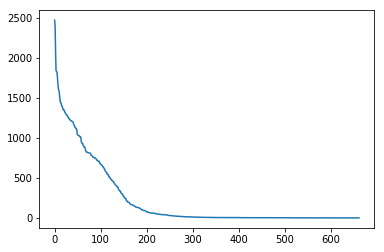

In [14]:
out = np.concatenate(mona_classes).ravel().tolist()
c = Counter(out)
most_common_mass, most_common_freq = zip(*c.most_common())
plt.plot(range(len(most_common_freq)), most_common_freq)

In [15]:
keep_classes = set(most_common_mass[0:200])
filtered_mona_smiles = []
filtered_mona_classes = []
for i in range(len(mona_smiles)):
    smile = mona_smiles[i]
    classes = mona_classes[i]
    filtered = list(filter(lambda x: x in keep_classes, classes))
    if len(filtered) > 0:
        filtered_mona_smiles.append(mona_smiles[i])
        filtered_mona_classes.append(filtered)
mona_smiles = filtered_mona_smiles
mona_classes = filtered_mona_classes

In [16]:
c = Counter(np.concatenate(mona_classes).ravel().tolist())
# c.most_common()

In [17]:
input_array = get_input_arr(mona_smiles, charset)
mona_latent = encode(model, input_array)

In [18]:
mlb = MultiLabelBinarizer()
X = mona_latent
y = mlb.fit_transform(mona_classes)
indices = np.arange(len(X))

In [19]:
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X, y, indices, test_size=0.20)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7478, 100)
(7478, 200)
(1870, 100)
(1870, 200)


### Set up model

In [29]:
EPOCHS = 100
BATCH_SIZE = 32
OUTPUT_SIZE = y_train.shape[1]

def get_model(model_choice):
    if model_choice == 1:
        model = Sequential()
        model.add(Dense(32, input_dim=LATENT_DIM, activation='relu'))
        model.add(Dense(OUTPUT_SIZE, activation='sigmoid'))
    elif model_choice == 2:
        model = Sequential()
        model.add(Dense(64, input_dim=LATENT_DIM, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(OUTPUT_SIZE, activation='sigmoid'))
    elif model_choice == 3:
        model = Sequential()
        model.add(Dense(64, input_dim=LATENT_DIM, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))        
        model.add(Dense(64, activation='relu'))        
        model.add(Dense(OUTPUT_SIZE, activation='sigmoid'))
    return model
        
model = get_model(3)
model.summary()
# plot_model(model, show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 200)               13000     
Total params: 23,656
Trainable params: 23,656
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])

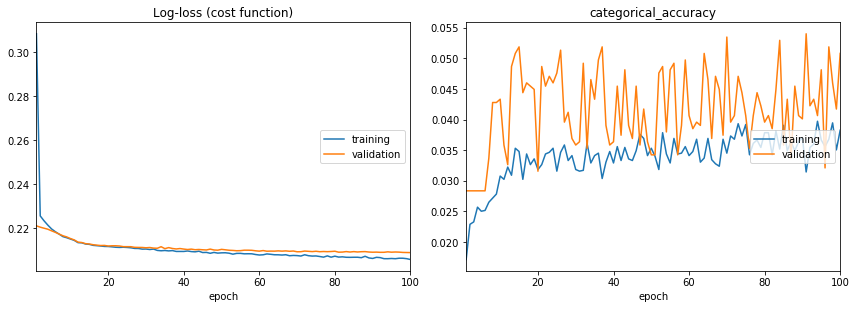

In [31]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), 
                    callbacks=[PlotLossesKeras()])

In [32]:
# model.save('results/embedding_large.hdf5')
# with open('results/embedding_large.history', 'wb') as f:
#     pickle.dump(history.history, f)

### Make some predictions

Poor results due to imbalanced classes

In [39]:
def predict(model, X_new, t, mlb):
    pred = (model.predict(X_new) > t).astype(int)
    return mlb.inverse_transform(pred)

# predict on some random validation data
NUM_RANDOM = 20
idx = np.random.choice(np.arange(len(X_val)), NUM_RANDOM, replace=False)
X_new = X_val[idx]
y_new = y_val[idx]
idx_new = idx_val[idx]
smiles_new = np.array(mona_smiles)[idx_new]
t = 0.5
for smile, actual, pred in zip(smiles_new, mlb.inverse_transform(y_new), predict(model, X_new, 0.20, mlb)):
    print('SMILES', smile)
    print('Actual   ', sorted(map(int, actual)))
    print('Predicted', sorted(map(int, pred)))
    print()

SMILES n1ccncc1
Actual    [81]
Predicted [65, 77, 91, 92, 93]

SMILES c1cc(N=Nc2ccccc2)ccc1
Actual    [67, 75, 77, 78, 81, 89, 92, 94, 95, 105, 106, 113, 115, 127, 128, 139, 140, 152, 153, 154, 155, 181, 182]
Predicted [65, 77, 91, 92, 93, 95, 105, 117, 119]

SMILES c1(NC(C)(C)C)nc(=N)nc(SC)[nH]1
Actual    [57, 68, 74, 85, 91, 110, 116, 128, 143, 158, 214]
Predicted [68, 71, 79, 96, 110, 128, 138, 146]

SMILES C(=O)(CCl)N(C(C)C)c1ccccc1
Actual    [76, 77, 79, 91, 93, 94, 95, 106, 125, 134, 152, 170]
Predicted [65, 77, 79, 91, 92, 93, 94, 95, 105, 106, 107, 117, 118, 119, 120, 121, 132, 133, 134]

SMILES N1CCCCC1
Actual    [69, 86]
Predicted [56, 58, 70]

SMILES NCC1(C)CC(N)CC(C)(C)C1
Actual    [137, 154]
Predicted [95]

SMILES CNC1=CC=CC=C1C(=O)O
Actual    [41, 43, 44, 54, 57, 59, 73, 76, 78, 80, 89, 91, 98, 105, 106, 107, 108, 116, 117, 119, 133, 135, 152]
Predicted []

SMILES CNC[C@H](O)c(c1)cc(O)c(O)c1
Actual    [100, 101, 105, 107, 116, 117, 119, 121, 122, 123, 124, 133, 135, 137, 